In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


data_list = list()

for i in range (155,255):
    with open (f'../datafile_new/datafile{i}.txt') as _f:
        data = _f.read().split('\n')
        _d = data[1:-1]
    
    data_list.extend(_d)

final_list = list()
for i in range (int(len(data_list)/100)):
    _d = data_list[100*(i-1) : 100*i]
    loss_packets = len([_data for _data in _d if _data == 'None'])
    final_list.append(loss_packets)
final_list = np.array(final_list)
print(len(final_list))


dataset = final_list.astype(np.float32)
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))
n = 2

def create_dataset(dataset, look_back=n):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

train_X = train_X.reshape(-1, 1, n)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, n)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)

from torch import nn
from torch.autograd import Variable
test_loss = list()
class lstm(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layer):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = self.dropout(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x
output = 2
model = lstm(n,4,2,3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# 开始训练
for e in range(500):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    pred = out.argmax(dim=1)

    num_correct = 1
    num_correct = torch.eq(pred, var_y).sum()
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    test_loss.append(loss.item())

torch.save(model, f'./packetloss_net_{n}.pkl')
    
model = model.eval() # 转换成测试模式

data_X = data_X.reshape(-1, 1, n)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'g', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')
plt.title('The graph of prediction and real dataset')
plt.show()



30000


/var/folders/ds/lnt43mls129cb8n4b_0_fkhr0000gn/T/ipykernel_32183/1588373577.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dataX), np.array(dataY)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

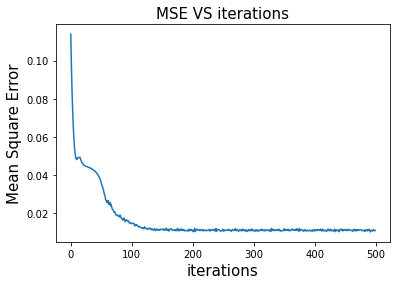

In [45]:

fontsize = {'size' : 15}
plt.plot(test_loss)
plt.xlabel('iterations', fontdict=fontsize)
plt.ylabel('Mean Square Error', fontdict=fontsize)
plt.title('MSE VS iterations', fontdict=fontsize)
plt.savefig(f'output_prediction_step/{n}ahead/loss_iter.png', dpi = 300)

In [7]:
for sample_num in range (1, 40):
    y_2 = int (30000 - n - 300 * (sample_num-1))
    y_1 = y_2 - 300 + n + 10
    print (y_1, y_2)
    y = pred_test[y_1:y_2].tolist()
    yy = list()
    fontsize = {
        'size': 20
    }
    cnt = 0
    for _y in y:
        if _y == max(y):
            cnt = 1
        if cnt == 1:
            _y = max(y)

        yy.append(_y)
    del(y)
    _y_2 = int (30000 - 300 * (sample_num-1))
    _y_1 = _y_2 - 300 + 10
    _y = dataset[_y_1:_y_2]
    x = np.arange(0,len(_y)).tolist()
    _x = np.arange(0,len(_y)).tolist()
    plt.figure()
    yy = [None] * n + yy
    plt.plot(x, yy, 'g', label='prediction')
    plt.plot(_x, _y, 'r', label='real')
    plt.legend(loc = 'best')
    plt.title('Prediction of packet loss rate', fontdict=fontsize)
    plt.xlabel('number of time slots (time slot is 100s)', fontdict=fontsize)
    plt.ylabel('packetloss rate / 100%',fontdict=fontsize)
    plt.text(21, 0.3, f'Prediction made {n} slots ahead',fontdict={'size': 13})
    plt.savefig(f'output_prediction_step/{n}ahead/test/packetloss_net_{sample_num}_{n}.png',dpi=300)
    plt.close()
    plt.figure()
    plt.plot(x, yy, 'g', label='prediction')
    plt.plot(_x, _y, 'r', label='real')
    plt.legend(loc = 'best')
    plt.title('enlarged prediction area', fontdict=fontsize)
    plt.xlim(250, 300)
    plt.xticks(np.arange(250, 300, 5))
    plt.grid()
    plt.xlabel('number of time slots (time slot is 100s)', fontdict=fontsize)
    plt.ylabel('packetloss rate / 100%',fontdict=fontsize)
    plt.savefig(
        f'output_prediction_step/{n}ahead/test_magnified/packetloss_net_{n}_magnified_sample\{sample_num}.png',
        dpi=300
    )
    plt.close()

29710 29995
29410 29695
29110 29395
28810 29095
28510 28795
28210 28495
27910 28195
27610 27895
27310 27595
27010 27295
26710 26995
26410 26695
26110 26395
25810 26095
25510 25795
25210 25495
24910 25195
24610 24895
24310 24595
24010 24295
23710 23995
23410 23695
23110 23395
22810 23095
22510 22795
22210 22495
21910 22195
21610 21895
21310 21595
21010 21295
20710 20995
20410 20695
20110 20395
19810 20095
19510 19795
19210 19495
18910 19195
18610 18895
18310 18595


In [38]:

model_pkloss = torch.load(f'./packetloss_net_{n}.pkl')

with open (f'../datafile_new/datafile{2}.txt') as _f:
        data = _f.read().split('\n')
        data_200 = data[1:-1]
final_200 = list()
for i in range (int(len(data_200)/100)):
    _d = data_200[100*(i-1) : 100*i]
    loss_packets = len([_data for _data in _d if _data == 'None'])
    final_200.append(loss_packets)
final_200 = np.array(final_200)

dataset_200 = final_200.astype(np.float32)
max_value = np.max(dataset_200)
min_value = np.min(dataset_200)
scalar = max_value - min_value
dataset_200 = list(map(lambda x: x / scalar, dataset_200))
model_pkloss.eval()
X = np.array(dataset_200)
X =X.reshape(-1, 1, n)
print (X)
data_200 = torch.from_numpy(X)
var_200 = Variable(data_200)
pred_test_200 = model(var_200)



[[[0.         0.01428571]]

 [[0.         0.01428571]]

 [[0.01428571 0.        ]]

 [[0.01428571 0.01428571]]

 [[0.         0.02857143]]

 [[0.01428571 0.01428571]]

 [[0.         0.01428571]]

 [[0.         0.        ]]

 [[0.         0.        ]]

 [[0.01428571 0.        ]]

 [[0.04285714 0.        ]]

 [[0.         0.04285714]]

 [[0.01428571 0.01428571]]

 [[0.02857143 0.        ]]

 [[0.01428571 0.        ]]

 [[0.04285714 0.01428571]]

 [[0.01428571 0.01428571]]

 [[0.         0.        ]]

 [[0.         0.01428571]]

 [[0.         0.        ]]

 [[0.         0.        ]]

 [[0.05714286 0.        ]]

 [[0.         0.01428571]]

 [[0.         0.01428571]]

 [[0.         0.02857143]]

 [[0.02857143 0.        ]]

 [[0.         0.01428571]]

 [[0.         0.02857143]]

 [[0.         0.01428571]]

 [[0.         0.01428571]]

 [[0.02857143 0.        ]]

 [[0.02857143 0.02857143]]

 [[0.         0.01428571]]

 [[0.01428571 0.01428571]]

 [[0.         0.01428571]]

 [[0.         0.0285

In [55]:
pred_test_200.tolist()

[[[0.08894705772399902, 0.08888424187898636]],
 [[0.037292465567588806, 0.037198565900325775]],
 [[0.0017609074711799622, 0.0016477704048156738]],
 [[-0.0031427517533302307, -0.0032586753368377686]],
 [[0.008047275245189667, 0.00793321430683136]],
 [[0.014531485736370087, 0.014415796846151352]],
 [[0.017522893846035004, 0.017405271530151367]],
 [[0.014564760029315948, 0.01444440707564354]],
 [[0.014601975679397583, 0.014481335878372192]],
 [[0.016395509243011475, 0.016275182366371155]],
 [[0.020382728427648544, 0.020263172686100006]],
 [[0.03290009871125221, 0.03278356418013573]],
 [[0.025257743895053864, 0.025136154145002365]],
 [[0.02111150696873665, 0.020989134907722473]],
 [[0.018245186656713486, 0.018122762441635132]],
 [[0.026768725365400314, 0.02664962410926819]],
 [[0.024199962615966797, 0.024078823626041412]],
 [[0.01723601669073105, 0.017112955451011658]],
 [[0.021026503294706345, 0.02090570703148842]],
 [[0.016310494393110275, 0.016188085079193115]],
 [[0.015579037368297577,

In [54]:
data_200

tensor([[[0.0000, 0.0143]],

        [[0.0000, 0.0143]],

        [[0.0143, 0.0000]],

        [[0.0143, 0.0143]],

        [[0.0000, 0.0286]],

        [[0.0143, 0.0143]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0000]],

        [[0.0000, 0.0000]],

        [[0.0143, 0.0000]],

        [[0.0429, 0.0000]],

        [[0.0000, 0.0429]],

        [[0.0143, 0.0143]],

        [[0.0286, 0.0000]],

        [[0.0143, 0.0000]],

        [[0.0429, 0.0143]],

        [[0.0143, 0.0143]],

        [[0.0000, 0.0000]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0000]],

        [[0.0000, 0.0000]],

        [[0.0571, 0.0000]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0286]],

        [[0.0286, 0.0000]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0286]],

        [[0.0000, 0.0143]],

        [[0.0000, 0.0143]],

        [[0.0286, 0.0000]],

        [[0.0286, 0.0286]],

        [[0.0000, 0.0143]],

        [[0.0143, 0.0143]],

        [[0.00

In [50]:
_pred = np.array(pred_test_200.tolist())
_orig = np.array(data_200)

plot_table = {
    'original': _orig,
    'prediction': _pred
}

In [44]:
for test_num in range (1,2):
    model_pkloss = torch.load(f'./packetloss_net_{n}.pkl')

    with open (f'../datafile_new/datafile{test_num}.txt') as _f:
            data = _f.read().split('\n')
            data_200 = data[1:-1]
    final_200 = list()
    for i in range (int(len(data_200)/100)):
        _d = data_200[100*(i-1) : 100*i]
        loss_packets = len([_data for _data in _d if _data == 'None'])
        final_200.append(loss_packets)
    final_200 = np.array(final_200)

    dataset_200 = final_200.astype(np.float32)
    max_value = np.max(dataset_200)
    min_value = np.min(dataset_200)
    scalar = max_value - min_value
    dataset_200 = list(map(lambda x: x / scalar, dataset_200))
    X, Y = create_dataset(dataset_200)
    print (n)
    model_pkloss.eval()
    X =X.reshape(-1, 1, n)
    data_200 = torch.from_numpy(X)
    var_200 = Variable(data_200)
    print (len(var_200))
    pred_test_200 = model(var_200)
    pred_test_200 = pred_test_200.view(-1).data.numpy()

    # 画出实际结果和预测的结果
    pred_test_200 = [None] * n + list(pred_test)
    plt.plot(pred_test_200, 'g', label='prediction')
    plt.plot(dataset_200, 'b', label='real')
    plt.legend(loc='best')
    plt.title('Generalization Test of model')
    plt.xlabel('number of time-period (100s)')
    plt.ylabel('rate of packet loss (*100%)')
    plt.savefig(f'output_prediction_step/{n}ahead/Generalisation/Generalization test sample_{n}_{test_num}', dpi=300)
    plt.close()



5
295
